## Fera Formidável 4.8

### “… o futuro, assim como o passado, seriam presente diante de seus olhos” — Pierre-Simon de Laplace

#### Rômulo 24024

### Enunciado:
**Objetivo:** implementar uma rede neural recorrente (RNN) utilizando PyTorch ou
lightning. Treine esta rede neural em um conjunto de dados sequenciais. Explique para
o leitor como funciona a recorrência de uma RNN e o motivo de utilizarmos este tipo de
arquitetura quando estudamos dados sequenciais.

### Introdução:
Redes neurais recorrentes, ou RNNs (Recurrent Neural Networks), são redes neurais especializadas em operar com dados sequenciais. Isso ocorre porque, diferentemente das redes neurais do tipo *feedforward*, que propagam a informação diretamente de camada em camada, as RNNs contêm loops em sua estrutura, ou seja, saídas de camadas anteriores são levadas em consideração nas próximas. Isso faz com que o modelo funcione bem com dados em que a ordem importa. Redes neurais recorrentes são amplamente utilizadas em modelos preditivos de dados sequenciais, classificação de sequências e modelos de linguagem.

#### Arquitetura de uma RNN:
A RNN possui um componente chamado estado oculto(hidden state), que considera o output das etapas anteriores. Após cada passo da sequência, o hidden state é atualizado, tornando o próximo passo dependente dos anteriores.

#### Problemas com RNNs:
Como cada passo depende dos anteriores, os gradientes calculados nas etapas iniciais tendem a ser muito maiores ou menores do que os das etapas finais. Se a rede for muito longa, as últimas camadas podem ter gradientes extremamente pequenos, causando o chamado desvanecimento do gradiente (vanishing gradient). Por outro lado, também pode ocorrer o explosão do gradiente (exploding gradient), tornando o treinamento instável.

#### LSTM:
Long Short-Term Memory (LSTM) é um tipo de rede neural recorrente que busca minimizar esses problemas relacionados aos gradientes. Além do hidden state, ela possui o cell state, que armazena informações de longo prazo, que juntos armazenam informações relevantes ao longo da sequência. A LSTM também introduz portas (gates) que controlam o fluxo de informação, decidindo o que lembrar e o que esquecer, tornando a rede mais eficaz em sequências longas.

#### Guia da Aventura:
Vamos utilizar uma RNN do tipo LSTM para classificar caracteres manuscritos com base em dados sequenciais: a movimentação do objeto utilizado para escrever (variação das coordenadas x e y) e a pressão aplicada sobre a superfície ao longo do tempo. Para isso, dividiremos os dados em conjuntos de treino e teste, e realizaremos o batching dos dados. Cada lote terá três dimensões: tamanho do lote, comprimento da sequência e número de variáveis de entrada (neste caso, 3).

Em seguida, treinaremos um modelo contendo uma camada de LSTM com duas camadas internas e 256 unidades ocultas, seguida por duas camadas totalmente conectadas (lineares), com 64 e 20 neurônios, respectivamente. A função de ativação ReLU será aplicada entre as camadas lineares. Como se trata de um problema de classificação, usaremos a função de perda CrossEntropyLoss e o otimizador Adam. Após o treinamento, avaliaremos o modelo com o conjunto de teste, calculando a perda média e a acurácia final.

#### Observação: 
Os dados originais estavam num formato .dat, tentei converter para csv e não consegui, pedi para o chat GPT me gerar o CSV, ele separou cada amostra num arquivo diferente, são 2858 amostras, o padding já havia sido feito em quase todos, com 179 sequências, mas haviam 2 arquivos errados, um com 176, outro com 178. Os rótulos foram salvos num arquivo único chamado labels, podemos recuperar a associação à amostra através do índices. Além da conversão, ele me ajudou a entender a arquitetura dos dados, e entender sobre a necessidade do padding. Os dados já vêm normalizados.

Acesso à conversa: 
https://chatgpt.com/share/682b0425-d70c-8013-b2fe-661c1c7e549a

#### Imports necessários:

In [1]:
import pandas as pd
import random as rd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



SEED = 42 # Adicionar reprodutibilidade dos resultados
torch.manual_seed(SEED)
rd.seed(SEED)

os.chdir('C:\\Users\\romulo24024\\OneDrive - ILUM ESCOLA DE CIÊNCIA\\RedesNeuraisAlgoritmosGenéticos\\Datasets\\Characteres')

Split treino e teste:

In [2]:
train_index = rd.sample(range(2858), k = 2000)
val_index = rd.sample([x for x in range(2858) if x not in train_index], k=429)
test_index = [x for x in range(2858) if x not in train_index and x not in val_index]
data_y_true = pd.read_csv('output_csvs/labels.csv') # Os dados de rótulos estão num arquivo só

ordem_labels_number = []
for label in data_y_true['label_num']:
    if label not in ordem_labels_number:
        ordem_labels_number.append(label)

ordem_labels_char = []
for label in data_y_true['label_char']:
    if label not in ordem_labels_char:
        ordem_labels_char.append(label)

Lendo as sequencias dos dados de treino e de teste:
Eles estão em arquivos diferentes, estou juntando para numa lista para favorecer o loteamento.

In [3]:
sequence_list_train, y_true_train = zip(*[
    (torch.tensor(pd.read_csv(f'output_csvs/sample_{i+1}.csv').values, dtype=torch.float32), data_y_true.iloc[i]['label_num'])
    for i in train_index
])

sequence_list_val, y_true_val = zip(*[
    (torch.tensor(pd.read_csv(f'output_csvs/sample_{i+1}.csv').values, dtype=torch.float32),data_y_true.iloc[i]['label_num'])
    for i in val_index
])

sequence_list_test, y_true_test = zip(*[
    (torch.tensor(pd.read_csv(f'output_csvs/sample_{i+1}.csv').values, dtype=torch.float32),data_y_true.iloc[i]['label_num'])
    for i in test_index
])

Criei uma função para criar os lotes de treino e teste, o parâmetro shuffle serve para eu poder utilizar a mesma função para os dados de treino e teste. Os dados já retornam em tensores de lote com as dimensões desejadas.

In [4]:
def segmenta_batch_sequencial(sequence_list: list, y_true: list, batch_size: int, shuffle: bool = False):
    batches = []

    if shuffle: # Verdadeiro em dados de treino
        combined = list(zip(sequence_list, y_true))
        rd.shuffle(combined)
        sequence_list, y_true = zip(*combined)
    else:
        sequence_list, y_true = list(sequence_list), list(y_true)

    for i in range(0, len(sequence_list), batch_size):
        batch = sequence_list[i:i + batch_size]
        y_true_batched = y_true[i:i + batch_size]

        padded_batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True)
        y_true_tensor = torch.tensor([y-1 for y in y_true_batched], dtype=torch.long)
        batches.append((padded_batch, y_true_tensor))

    return batches

batches_train = segmenta_batch_sequencial(sequence_list_train, y_true_train, batch_size=250, shuffle=True)
batches_val = segmenta_batch_sequencial(sequence_list_val, y_true_val, batch_size=143, shuffle=False)
batches_test = segmenta_batch_sequencial(sequence_list_test, y_true_test, batch_size=143, shuffle=False)

Criando a classe RNN:

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.rnn = nn.LSTM(input_size=3, hidden_size=178, num_layers=2, batch_first=True) # Nossa camada capaz de trabalhar com dados sequenciais
        # Começamos com 3 dados de entrada associados à posição e força de pressão o hidden size foi escolhido com base o max_seq_len – 1
        
        self.fc1 = nn.Linear(178, 112)
        self.fc2 = nn.Linear(112, 56)
        self.fc3 = nn.Linear(56, num_classes) # Depois dela já temos que retornar as 20 classes desejadas, não são todas as letras do nosso alfabeto possíveis
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # Os outputs de hidden state final e cell state final são desprezíveis
        rnn_out = rnn_out[:, -1, :] # Devemos levar em consideração somente o output da última sequência, ele já leva em consideração os anteriores 
        
        x = self.relu(self.fc1(rnn_out))
        x = self.fc2(x)
        x = self.fc3(x) 
        return x

Criando o nosso modelo:

In [6]:
model = LSTMClassifier(20)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Treinando o nosso modelo:
*** Não adicionei dados de validação nem regularizador, o número de épocas foi escolhido evitando overfitting com base em testes.

In [7]:
epochs = 230 # Número de épocas alto pois o modelo demora a convergir, as épocas iniciais têm desempenho comparável a chutes
train_loss = []
val_loss = []
for epoch in range(epochs):
    model.train()
    model.train()
    epoch_loss_train = []
    correct_train = 0
    total_train = 0
    for batch in batches_train:
        outputs = model(batch[0])
        labels = batch[1]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        epoch_loss_train.append(loss.item())

    mean_train_loss = sum(epoch_loss_train) / len(batches_train)
    train_loss.append(mean_train_loss)
    accuracy_train = correct_train / total_train

    with torch.no_grad():
        model.eval()
        epoch_loss_val = []
        correct_val = 0  
        total_val = 0
        for batch in batches_val:
            output = model(batch[0])
            labels = batch[1]

            _, predicted = torch.max(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            loss = criterion(output, labels)
            epoch_loss_val.append(loss.item())

    accuracy_val = correct_val / total_val
    mean_val_loss = sum(epoch_loss_val) / len(epoch_loss_val)
    val_loss.append(mean_val_loss)

    print(f"Época {epoch+1}/{epochs}")
    print(f"Perda no treino: {mean_train_loss:.4f}, Acurácia no treino: {accuracy_train:.4f}")
    print(f"Perda na validação: {mean_val_loss:.4f}, Acurácia na validação: {accuracy_val:.4f}")

Época 1/230
Perda no treino: 3.0002, Acurácia no treino: 0.0500
Perda na validação: 2.9936, Acurácia na validação: 0.0606
Época 2/230
Perda no treino: 2.9927, Acurácia no treino: 0.0660
Perda na validação: 2.9956, Acurácia na validação: 0.0606
Época 3/230
Perda no treino: 2.9889, Acurácia no treino: 0.0660
Perda na validação: 2.9988, Acurácia na validação: 0.0606
Época 4/230
Perda no treino: 2.9867, Acurácia no treino: 0.0675
Perda na validação: 3.0049, Acurácia na validação: 0.0839
Época 5/230
Perda no treino: 2.9875, Acurácia no treino: 0.0780
Perda na validação: 2.9957, Acurácia na validação: 0.0839
Época 6/230
Perda no treino: 2.9844, Acurácia no treino: 0.0785
Perda na validação: 2.9902, Acurácia na validação: 0.0466
Época 7/230
Perda no treino: 2.9511, Acurácia no treino: 0.0740
Perda na validação: 2.9456, Acurácia na validação: 0.0839
Época 8/230
Perda no treino: 2.9376, Acurácia no treino: 0.0985
Perda na validação: 2.9528, Acurácia na validação: 0.0816
Época 9/230
Perda no tre

Teste com dados de teste:

In [8]:
prediction_test = []
with torch.no_grad():
    model.eval()
    test_loss = []
    correct = 0  
    total = 0
    for batch in batches_test:
        output = model(batch[0])
        labels = batch[1]

        _, predicted = torch.max(output, 1)
        prediction_test.append(predicted)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loss = criterion(output, labels)
        test_loss.append(loss.item())

    accuracy = correct / total
    mean_test_loss = sum(test_loss) / len(test_loss)
    print(f"Perda no teste: {mean_test_loss:.4f}, Acurácia no teste: {accuracy:.4f}")

Perda no teste: 0.2297, Acurácia no teste: 0.9394


Vamos agora plotar a matriz de confusão:

[Text(0.5, 23.52222222222222, 'Predito'),
 Text(50.722222222222214, 0.5, 'Real')]

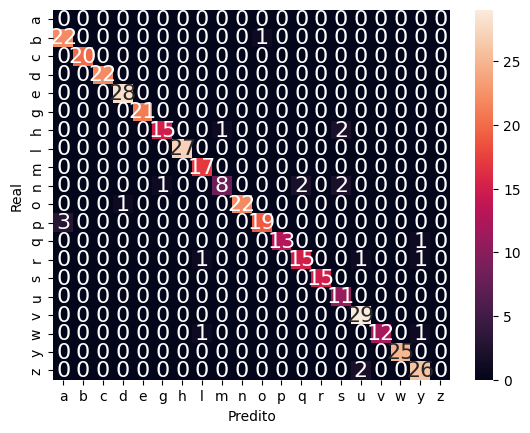

In [10]:
predictions_test = torch.cat(prediction_test).tolist()
matriz_conf = confusion_matrix(y_true_test, predictions_test, labels=ordem_labels_number)

df_conf = pd.DataFrame(matriz_conf, ordem_labels_char, ordem_labels_char)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16})
eixo.set(xlabel="Predito", ylabel="Real")

#### Conclusão:

O uso da arquitetura LSTM foi essencial neste trabalho, já que ela lida muito bem com dados sequenciais, como as trajetórias de caracteres manuscritos. As LSTMs conseguem capturar dependências de longo prazo justamente porque têm mecanismos internos que controlam o que deve ser mantido ou esquecido ao longo do tempo. Isso faz toda a diferença aqui, onde cada amostra é uma sequência temporal de coordenadas e pressão, e a ordem dos eventos influencia diretamente na identificação correta do caractere.

Os resultados mostram que o modelo teve um bom desempenho, com alta acurácia tanto na validação quanto no teste. Isso indica que a LSTM foi capaz de aprender padrões importantes nas sequências para diferenciar os caracteres. A matriz de confusão mostra alguns erros entre classes parecidas, o que é esperado, mas no geral o modelo se saiu bem e generalizou para dados que não tinha visto antes.

Segundo o artigo usado como base, modelos como esse têm várias aplicações práticas, como reconhecimento de escrita à mão em tempo real, digitalização de documentos manuscritos, entrada de texto em dispositivos móveis e até análise de caligrafia em contextos educacionais. Como a LSTM considera não só o formato do traço, mas também a dinâmica do movimento, o sistema se torna mais preciso e adaptável a situações reais.

### Referências
- Dataset do UCI sobre trajetória dos caracteres

Williams, B. (2006). Character Trajectories [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C58G7V.

- Conversa com o chat GPT que gerou o código de conversão de dados:

Disponível em: <https://chatgpt.com/share/682b0425-d70c-8013-b2fe-661c1c7e549a>

- Artigo referência que mostra a utilidade do modelo preditivo:

Williams, Ben & Toussaint, Marc & Storkey, Amos. (2007). A Primitive Based Generative Model to Infer Timing Information in Unpartitioned Handwriting Data.. 1119-1124. 